<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>Construct a Custom Coadded Image</b> <br>
Contact author: Melissa Graham <br>
Last verified to run: 2022-10-04 <br>
LSST Science Piplines version: Weekly 2022_40 <br>
Container Size: large <br>
Targeted learning level: advanced <br>

In [ ]:
# %load_ext pycodestyle_magic
# %flake8_on
# import logging
# logging.getLogger("flake8").setLevel(logging.FATAL)

**Description:** Create a custom "deepCoadd" using only a subset of the input visits.

**Skills:** Use of pipetasks for image coaddition. Creating and writing to Butler collections. Properties of deepCoadds.

**LSST Data Products:** visitTable table, deepCoadd images

**Packages:** lsst.daf.butler, lsst.ctrl.mpexec, lsst.pipe.base

**Credit:** Originally developed by Melissa Graham and Clare Saunders.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

# 1. Introduction

This notebook shows how to retrieve information about the individual images that contributed to a deepCoadd, and how to make a new coadded image using only a subset of the inputs.

In the past you might have used iraf's imcombine or Astromatics's SWarp (for example) to coadd images.
This notebook demonstrates the appropriate methods for coadding LSST images with the LSST Science Pipelines.

Science applications of coadding a subsets of LSST images includes searching for faint, slowly-evolving transients or variables (e.g., coadding images by season), using the effects of differential chromatic refraction (e.g., coadding images in bins of airmass), or perhaps searching for low surface brightness features (e.g., coadding only dark-time images with the faintest sky backgrounds).

**Adopted Science Use Case: Supernova Precursor Events**<br>
This notebook tutorial uses the science case of a hypothetical supernova that occurred at RA 55.745834, Dec -32.269167 on MJD = 60960.
(There is no DC2 supernova there, we just use the coordinates as an example).
Since the deepCoadds are made out of years worth of images, and are combined to remove most transient flux, the supernova itself would not appear in the deepCoadd.
However, some supernovae are known to have faint precusor eruptions, and characterizing precursor events is useful for understanding the supernova progenitor star and, e.g., its pre-supernova mass-loss episodes.
It is possible to detect faint precursor eruptions by stacking images obtained prior to the supernova explosion.

**Caveats:**<br>

1. This science use case of supernova precurors would be much better achieved by stacking the difference images. However, we wanted to make this a tutorial that creates custom coadds, and our science background is supernovae. So there remains a bit of a mismatch between science use case and image type for this tutorial.

2. This tutorial uses only i-band visits to recreate coadds, but in reality scientists looking for supernova precusor events would use all filters (and that searching the bluer filters in particular would be more relevant).

3. This tutorial uses images obtained in a one-month window prior to the supernova, but in reality scientists looking for supernova precusor events would use more windows, further in the past. That is left as an exercise for the learner in Section 5.

See the next tutorial notebook in the series, 09b_Custom_Coadd_Sources.ipynb, to learn how to run source detection and measurement on the new custom coadd.

## 1.1. Package imports

Standard python and astropy packages for numerical processing, plotting, databases, unit conversion, etc.

LSST Science Pipelines packages for data access, display, sky coordinates, and pipeline tasks.

In [1]:
import time
import getpass
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas
from astropy.time import Time

import lsst.geom
import lsst.afw.display as afwDisplay
from lsst.daf.butler import Butler, DatasetType, CollectionType
from lsst.ctrl.mpexec import SimplePipelineExecutor
from lsst.pipe.base import Pipeline, Instrument

## 1.2. Define functions and parameters

Set a few parameters related to plotting and display.

In [2]:
font = {'size': 14}
matplotlib.rc('font', **font)

pandas.set_option('display.max_rows', 1000)

afwDisplay.setDefaultBackend('matplotlib')

Set the DP0.2 config and collection, and instantiate a butler.

In [3]:
butler = Butler('dp02', collections='2.2i/runs/DP0.2')

**Option:** display all the deepCoadd datasetTypes available via the butler.

In [4]:
# for x in sorted(butler.registry.queryDatasetTypes('deepCoadd*')):
#     print(x)

# 2. Identify the visits to combine

This example starts with a given sky coordinate -- in this case, the right ascension and declination of a known galaxy cluster in the DC2 data set are used.

The DC2 skyMap is used to identify the i-band deepCoadd which contains that coordinate, and then the butler is used to retrieve the deepCoadd and the list of visit ids which were combined to create it.

The visitTable is then used to obtain the acquisition dates of the input visits.
For this example, the visits in a short time range will be selected as the visits to be coadded.

## 2.1. Identify and retrieve the deepCoadd

Define the RA, Dec, and filter to identify and retrieve the relevant deepCoadd.

This takes 4-5 seconds.

In [5]:
%%time

my_ra_deg = 55.745834
my_dec_deg = -32.269167
my_filter = 'i'

my_spherePoint = lsst.geom.SpherePoint(my_ra_deg*lsst.geom.degrees, my_dec_deg*lsst.geom.degrees)

skymap = butler.get('skyMap')
tract = skymap.findTract(my_spherePoint)
my_tract = tract.tract_id
my_patch = tract.findPatch(my_spherePoint).getSequentialIndex()
print('My tract and patch: ', my_tract, my_patch)

my_dataId = {'band': my_filter, 'tract': my_tract, 'patch': my_patch}
my_deepCoadd = butler.get('deepCoadd', dataId=my_dataId)

del my_ra_deg, my_dec_deg, my_filter, my_spherePoint, skymap, tract

My tract and patch:  4431 17
CPU times: user 3.84 s, sys: 1.28 s, total: 5.12 s
Wall time: 5.35 s


**Option:** display the deepCoadd image.

In [6]:
# fig = plt.figure(figsize=(6, 4))
# afw_display = afwDisplay.Display(1)
# afw_display.scale('asinh', 'zscale')
# afw_display.mtv(my_deepCoadd.image)
# plt.gca().axis('off')

**Option:** learn more about the deepCoadd metadata, such as bounding box, corners, and the World Coordinate System (WCS), by uncommenting and executing the cell below.
It is not necessary to know the bounding box for a deepCoadd in order to find all of the calexps that were used to assemble it, this is simply a demonstration for the learner.

In [7]:
# my_deepCoadd_bbox = butler.get('deepCoadd.bbox', dataId=my_dataId)
# print('bbox')
# print(my_deepCoadd_bbox.beginX, my_deepCoadd_bbox.beginY,
#       my_deepCoadd_bbox.endX, my_deepCoadd_bbox.endY)

# print('')
# print('corners')
# print(my_deepCoadd_bbox.getCorners())

# print('')
# print('wcs')
# my_deepCoadd_wcs = butler.get('deepCoadd.wcs', dataId=my_dataId)
# print(my_deepCoadd_wcs)

# del my_deepCoadd_bbox, my_deepCoadd_wcs

## 2.2. Retrieve the deepCoadd's input visits

In [8]:
my_coadd_inputs = my_deepCoadd.getInfo().getCoaddInputs()

The length of this table, 161, indicates that 161 separate visits contributed to this deepCoadd.

In [9]:
len(my_coadd_inputs.visits)

161

**Option:** display the information for the coadd inputs as an astropy table.

In [10]:
# my_coadd_inputs.visits.asAstropy()

**Option:** list all of the deepCoadd input visit IDs.

In [11]:
# my_coadd_visits = my_coadd_inputs.visits['id']
# my_coadd_visits

> **Notice:** the visitId is a unique identifier for a visit, which is a full-focal plane exposure obtained with at a specific time, at specific sky coordinates, in one filter. The visitID does not also uniquely identify the CCD (detector): that is called a ccdVisitId. 

## 2.3. Identify the acquisition dates for the input visits

First, get the entire visit table.

In [12]:
visitTableRef = list(butler.registry.queryDatasets('visitTable'))

In [13]:
visitTable = butler.get(visitTableRef[0])

**Option:** display the contents of the entire visitTable.

In [14]:
# visitTable

Retrieve the Modified Julian Dates (MJDs) of our coadd input visits.

The fact that the id column for both the my_coadd_inputs.visits table and the visitTable is the visit number (visit id) makes doing this a simple, single line of code.

In [15]:
my_coadd_visits_mjds = visitTable.loc[my_coadd_inputs.visits['id']]['expMidptMJD']

This list of MJDs have 161 elements, for the 161 separate visits contributed to this deepCoadd.

In [16]:
len(my_coadd_visits_mjds)

161

## 2.4. Identify input visits to combine into a new Coadd

Say, for the sake of a science example, that a supernova (SN) exploded on MJD = 60960.

As a user, we want to stack images first from the month before to look for a faint precursor, and then maybe also the month before that.

Thus, we identify input visits in two date ranges:

Window1: 60925 to 60955 (the month before)

Window2: 60885 to 60922 (the month before that)

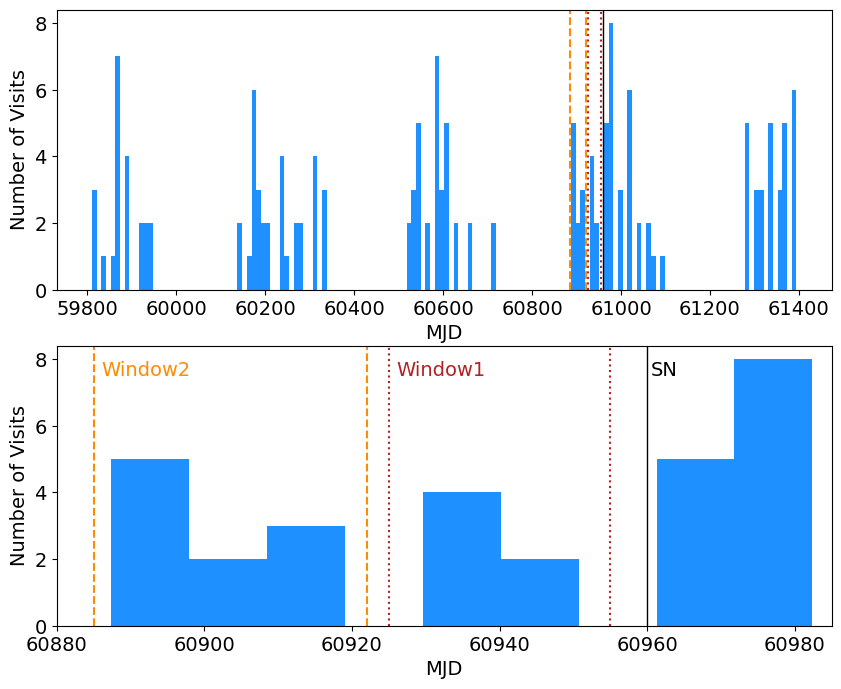

In [17]:
Window1_start = 60925
Window1_end = 60955

Window2_start = 60885
Window2_end = 60922

fig, ax = plt.subplots(2, figsize=(10, 8))

ax[0].axvline(60960, lw=1, ls='solid', color='black')
ax[0].hist(my_coadd_visits_mjds, bins=150, color='dodgerblue')
ax[0].set_xlabel('MJD')
ax[0].set_ylabel('Number of Visits')
ax[0].axvline(Window1_start, ls='dotted', color='firebrick')
ax[0].axvline(Window1_end, ls='dotted', color='firebrick')
ax[0].axvline(Window2_start, ls='dashed', color='darkorange')
ax[0].axvline(Window2_end, ls='dashed', color='darkorange')

ax[1].axvline(60960, lw=1, ls='solid', color='black')
ax[1].text(60960.5, 7.5, 'SN', color='black')
ax[1].hist(my_coadd_visits_mjds, bins=150, color='dodgerblue')
ax[1].set_xlabel('MJD')
ax[1].set_ylabel('Number of Visits')
ax[1].set_xlim([60880, 60985])
ax[1].axvline(Window1_start, ls='dotted', color='firebrick')
ax[1].axvline(Window1_end, ls='dotted', color='firebrick')
ax[1].text(Window1_start+1, 7.5, 'Window1', color='firebrick')
ax[1].axvline(Window2_start, ls='dashed', color='darkorange')
ax[1].axvline(Window2_end, ls='dashed', color='darkorange')
ax[1].text(Window2_start+1, 7.5, 'Window2', color='darkorange')

plt.show()

There are six visits in Window1, and ten in the earlier Window2.

# 3. Create a coadd for the visits in Window1

Put the list of visits for Window1 into a string, formatted as a tuple, for use in a query later on.
("Formatted as a tuple" means within round brackets and separated by commas).

Side note: in the future, changes might be made to the SimplePipelineExecutor (see below) so remove the need for users to reformat visitId lists as strings.

In [18]:
my_range = np.array((my_coadd_visits_mjds > Window1_start)
                    & (my_coadd_visits_mjds < Window1_end))
my_visits = my_coadd_inputs.visits[my_range]
my_visits_tupleString = "("+",".join(my_visits['id'].astype(str))+")"
print(my_visits_tupleString)

(919515,924057,924085,924086,929477,930353)


## 3.1. Name a new butler collection for your output

Use the convention `u/<Your User Name>/<Collection Identifier>` to set up a new butler output collection for this tutorial.

For `<Your User Name>`, recall that RSP user names are the same as GitHub user names, because GitHub accounts are used to authorize access to the RSP.

For `<Collection Identifier>`, for this notebook and for creating the coadd for Window1, use "coadd_recreation_nb/Window1_coadd".

The new coadd generated by this tutorial will be stored in the butler, just like the DP0 data sets generated by Rubin staff.
Everything stored in the butler is visible to all users.
All users should feel free to go ahead and build up a bunch of processed data in the butler. Rubin staff will reach out if this ever gets to be "too much" (unlikely).

> **Warning:** For DP0, the butler is a shared data repository, and everything stored in it is accessible to everyone. For DP0, there are no safeguards preventing users from deleting other people's data. Thus, for DP0, we are not teaching users how to delete _anything_ from the butler.

In [19]:
my_username = getpass.getuser()
print(my_username)

melissagraham


In [20]:
my_collection_identifier = 'coadd_recreation_nb/Window1_coadd'
print(my_collection_identifier)

coadd_recreation_nb/Window1_coadd


In [21]:
my_outputCollection = 'u/'+my_username+'/'+my_collection_identifier
print('Name of new butler collection for my output: ', my_outputCollection)

Name of new butler collection for my output:  u/melissagraham/coadd_recreation_nb/Window1_coadd


Check if this output collection already exists.

If nothing is printed below this cell, the output collection does not already exist.

In [22]:
for c in sorted(butler.registry.queryCollections()):
    if c.find(my_outputCollection) > -1:
        print(c)

u/melissagraham/coadd_recreation_nb/Window1_coadd
u/melissagraham/coadd_recreation_nb/Window1_coadd/20221015T011104Z


Delete the current butler. In the next section, a "simple butler" is created and used thereafter.

In [23]:
del butler

## 3.2. Set up a simple butler and name the output run for Window1

In order to save the custom coadd for Window1 to the butler, a new chained collection which combines the input collection and the output collection must be created.

In [24]:
simpleButler = SimplePipelineExecutor.prep_butler('dp02', inputs=['2.2i/runs/DP0.2'], output=my_outputCollection)

Check that the newly created output collection is first in the list.

> **Notice:** Below, see how a timestamp has been added to uniquely identify the outputs.
You would not be able to re-execute Section 3.6 without first re-executing Section 3.2 and creating a new output collection with a new timestamp, because the Butler will prevent you from overwriting.

In [25]:
simpleButler.registry.getCollectionChain(my_outputCollection)

CollectionSearch(('u/melissagraham/coadd_recreation_nb/Window1_coadd/20221015T014151Z', '2.2i/runs/DP0.2'))

**Option:** check the output collection run names that currently exist.

In [26]:
# for c in sorted(simpleButler.registry.queryCollections(my_outputCollection+'*')):
#     print('Found: ', c)

## 3.3. Create a pipeline with the makeWarp and assembleCoadd tasks

In order to combine the identified visits into a new Coadd, two steps of the larger Data Release Pipeline (DRP) must be included: `makeWarp` and `assembleCoadd`. 
Although warped images are created during processing, they are not stored long-term because they take up a lot of space and because they can be easily recreated when needed.

For more information, review the relevant documentation about <a href="https://pipelines.lsst.io/v/weekly/modules/lsst.pipe.base/creating-a-pipeline.html">creating a pipeline</a> or the <a href="https://pipelines.lsst.io/modules/lsst.pipe.tasks/tasks/lsst.pipe.tasks.assembleCoadd.AssembleCoaddTask.html">assembleCoadd<a> task.

**The `from_uri` method.**
    
The following method for creating the `assembleCoaddPipeline` task in a notebook -- using the `from_uri` function and passing a file path -- is not intuitive, but is preferred because it gives the user all of the configuration settings for the instrument automatically, and because it most closely replicates the command-line syntax.
    
A URI is a uniform resource identifier, and as seen below it can take both a file path and additional information: in this case, the additional information is the processing steps that we wish to use, which are defined in the file.

**The "yaml" file.**
    
A "yaml" file is a human-readable data-serialization language.
It is commonly used for configuration files and in applications where data is being stored or transmitted. 
    
The other tasks available are listed in the yaml file. 
To see the other tasks, first open a new terminal (click the blue + button at upper left and then select terminal).
Then create a Rubin Observatory environment, navigate to the yaml file used below, and view its contents with:
> `setup lsst_distrib` <br>
> `cd $DRP_PIPE_DIR/pipelines/LSSTCam-imSim/`<br>
> `more DRP-DP0.2.yaml`

You will see that this yaml file imports from other files, such as `$DRP_PIPE_DIR/ingredients/LSSTCam-imSim/DRP.yaml`.
Follow this redirect to view the imported yaml file contents.
We are using a yaml file with DP0-specific configurations. This is likely to change for future data previews.

> `cd $DRP_PIPE_DIR/ingredients/LSSTCam-imSim/`<br>
> `more DRP.yaml`

First create `my_uri`, a string that defines which parts of the Data Release Pipeline (DRP) will be included.

To create a custom coadd, only two steps need to be rerun: `makeWarp` and `assembleCoadd`. 
In the file `$DRP_PIPE_DIR/ingredients/LSSTCam-imSim/DRP.yaml`, you will find these defined as the first two sub-steps of `step3`, and that they are usually followed by the sub-step `detection`. 
However, we omit that sub-step and do source detection and measurement in the next tutorial notebook in this series, 09b_Custom_Coadd_Sources.ipynb.

In [27]:
yaml_file = '$DRP_PIPE_DIR/pipelines/LSSTCam-imSim/DRP-DP0.2.yaml'
steps = 'makeWarp,assembleCoadd'
my_uri = yaml_file + '#' + steps
print(my_uri)

$DRP_PIPE_DIR/pipelines/LSSTCam-imSim/DRP-DP0.2.yaml#makeWarp,assembleCoadd


Next create a pipeline including just `makeWarp` and `assembleCoadd` steps, and call it `assembleCoaddPipeline`.

In [28]:
assembleCoaddPipeline = Pipeline.from_uri(my_uri)

## 3.4. Configure the pipeline

There is only one configuration that must be set, and it is to clarify to the pipeline that it _does not_ need to redo a final image characterization step.
Currently, this configuration is only needed due to a version mismatch: the DP0.2 data sets were processed with Version 23 of the LSST Science Pipelines, whereas this notebook uses the version "Weekly 2022_40".

This configuration might not be needed in the future, and in general, users of this tutorial do not need to worry about other configuration changes.

Just as an FYI, configurations can be set using `addConfigOverride(<taskName>, <configName>, <configValue>)`.
Section 4.2.5. shows how to view the configurations that were used for a given run.

In [29]:
assembleCoaddPipeline.addConfigOverride('makeWarp', 'doApplyFinalizedPsf', False)

## 3.5. Create the full query string

Above, the visits to be recombined were stored in "my_visits_tupleString".

Below, the full query string is built to include the patch being recreated.

In [30]:
queryString = f"tract = {my_tract} AND patch = {my_patch} AND " + \
              f"visit in {my_visits_tupleString} AND skymap = 'DC2'"

print(queryString)

tract = 4431 AND patch = 17 AND visit in (919515,924057,924085,924086,929477,930353) AND skymap = 'DC2'


## 3.6. Use the Simple Pipeline Executor to run the pipeline

The <a href="https://pipelines.lsst.io/v/weekly/py-api/lsst.ctrl.mpexec.SimplePipelineExecutor.html">Simple Pipeline Executor</a> is a simple, high-level executor for pipelines that is primarily used for unit tests and small-scale integration of PipelineTask classes. It is appropriate to use in this case, where we are doing small-scale pipeline integration, in this case, of the makeWarp and assembleCoaddPipeline tasks only.

Learn more about the Simple Pipeline Executor.

In [31]:
# SimplePipelineExecutor.from_pipeline?

Set up the Simple Pipeline Executor. This step can take up to 5 minutes (and there have been reports of it taking even longer, up to 17 minutes).

In [32]:
%%time
spe = SimplePipelineExecutor.from_pipeline(assembleCoaddPipeline, where=queryString, butler=simpleButler)

CPU times: user 1.08 s, sys: 82.1 ms, total: 1.17 s
Wall time: 35.7 s


Run the pipeline.

There will be a lot of standard output. Alt-click to the left of the cell and choose "Enable Scrolling for Outputs" to condense all of the output into a scrollable inset window.

This takes about 20 minutes to coadd the 6 visits of Window1.

>**Notice:** Recall from Section 3.2 that the Butler will not overwrite existing data.
If you've already executed the cell below, and then you attempt to re-execute it without first re-executing the cell in Section 3.2 that instantiates the simpleButler with an output collection that has a unique timestamp, an error message will be returned.

In [33]:
%%time
quanta = spe.run()

CPU times: user 16min 6s, sys: 2min 6s, total: 18min 12s
Wall time: 17min 29s


# 4. Display and analyze the results

## 4.1. The quanta

The "quanta" that was just created is a list of objects corresponding to each of the pipeline tasks that were ran.
There will be one for each visit’s makeWarp and one for assembleCoadd.
Each of those has information about, e.g., the name of the task, the reference to the input and output.

**Option:** learn more about the quanta.

In [ ]:
# quanta

**Option:** to see the pop-up window of methods for quanta, put your cursor after the period and press the tab key.

In [ ]:
# quanta.

**Option:** instead of using tab, see the methods associated with an object by using "dir".

In [52]:
# dir(quanta[0])

Display the task names for each quantum in quanta to find the one associated with the assembleCoadd task.

In [34]:
for q, quantum in enumerate(quanta):
    print(q, quantum.taskName)

0 lsst.pipe.tasks.makeWarp.MakeWarpTask
1 lsst.pipe.tasks.makeWarp.MakeWarpTask
2 lsst.pipe.tasks.makeWarp.MakeWarpTask
3 lsst.pipe.tasks.makeWarp.MakeWarpTask
4 lsst.pipe.tasks.makeWarp.MakeWarpTask
5 lsst.pipe.tasks.makeWarp.MakeWarpTask
6 lsst.pipe.tasks.assembleCoadd.CompareWarpAssembleCoaddTask


When this tutorial was prepared, the output of the cell above showed that the first six elements of quanta (indices 0 through 5) were the results of makeWarp for the six visits, and then the seventh (index 6) was the results of `assembleCoadd`.

Below, set `coadd_index` equal to the index for the outputs of `lsst.pipe.tasks.assembleCoadd`.

This should be the same unless you've changed how many visits are input to the custom coadd.

> E.g., `coadd_index = 6`

In [35]:
coadd_index = 6

**Option:** display information using the `inputs` and `outputs` methods for quanta.

In [36]:
# quanta[coadd_index].inputs

In [37]:
# quanta[coadd_index].outputs

In [38]:
for output in quanta[coadd_index].outputs:
    print(output)

DatasetType('assembleCoadd_log', {band, skymap, tract, patch}, ButlerLogRecords)
DatasetType('deepCoadd', {band, skymap, tract, patch}, ExposureF)
DatasetType('deepCoadd_inputMap', {band, skymap, tract, patch}, HealSparseMap)
DatasetType('assembleCoadd_metadata', {band, skymap, tract, patch}, PropertySet)
DatasetType('deepCoadd_nImage', {band, skymap, tract, patch}, ImageU)


The deepCoadd is the output we're interested in. Notice that it has a DatasetType of ExposureF, so it is the image.

In [39]:
quanta[coadd_index].outputs['deepCoadd']

[DatasetRef(DatasetType('deepCoadd', {band, skymap, tract, patch}, ExposureF), {band: 'i', skymap: 'DC2', tract: 4431, patch: 17})]

From the square brackets, it's a list of just one element. So the DatasetRef for just our new coadd would be:

> `quanta[coadd_index].outputs['deepCoadd'][0]`

The above output is used in Section 4.2.1, below, to retrieve the new custom coadd image from the simpleButler.

## 4.2. The new image

Although the new custom coadd that we created is not a "deepCoadd", but a rather shallow coadd, it will still be called "deepCoadd" in the butler because that is the default name of results from the `assembleCoadd` task.

> **Notice:** Only use 4.2.1 "Option 1" ***OR*** 4.2.2 "Option 2" to retrieve the new image.

### 4.2.1. Option 1 - use the quanta

In [45]:
my_new_deepCoadd = simpleButler.get(quanta[coadd_index].outputs['deepCoadd'][0])

### 4.2.2. Option 2 - use the dataId

The dataId for the deepCoadd of interest was already defined:
> `my_dataId = {'band': 'i', 'tract': my_tract, 'patch': my_patch}`

Use it to retrieve the newly made Coadd (which is named deepCoadd by default) from the simple butler.

So long as you use the simpleButler, it will search the collections in order, and since we made sure that the new collection we just created and wrote to appears first -- as checked in the first cell below -- it will take the deepCoadd from that new collection.

In [ ]:
# simpleButler.registry.getCollectionChain(my_outputCollection)

In [ ]:
# my_new_deepCoadd = simpleButler.get('deepCoadd', dataId=my_dataId)

#### Accessing your results in another notebook.

The results have been permanently written to the butler.

If you instantiated a new butler in a new notebook: <br>
`collection = "u/<Your User Name>/coadd_recreation_nb/Window1_coadd/<Unique Timestamp>"`<br>
`butler = Butler('dp02', collections=collection)`<br>

Then you would be able to define the dataId in the same way:<br>
`my_dataId = {'band': 'i', 'tract': 4431, 'patch': 17}`<br>

And retrieve your new deepCoadd with:<br>
`my_new_deepCoadd = Butler.get('deepCoadd', dataId=my_dataId)`.

Since we already have our collection in the `simpleButler`, we don't need this option in this notebook.

This will be demonstrated in tutorial notebook 09b_Custom_Coadd_Sources.ipynb.

### 4.2.3. Check the inputs of the new Coadd

Check the inputs of my_new_deepCoadd, and compare them with the "queryString", and see that they match.

> **Notice:** With Weekly 41 it should be possible to do: <br>
> `my_new_deepCoadd_inputs = simpleButler.get("deepCoadd.coaddInputs", my_dataId, storageClass="AstropyTable")` <br>
> to have the results returned as an astropy table with a single command, instead of the two below.

In [46]:
my_new_deepCoadd_inputs = simpleButler.get("deepCoadd.coaddInputs", my_dataId)

In [47]:
my_new_deepCoadd_inputs.visits.asAstropy()

id,bbox_min_x,bbox_min_y,bbox_max_x,bbox_max_y,goodpix,weight,filter
,pix,pix,pix,pix,,,
int64,int32,int32,int32,int32,int32,float64,str32
919515,11900,7900,16099,12099,8982709,3.4656688819793495,i_sim_1.4
924057,11900,7900,16099,12099,16098179,4.384267091685517,i_sim_1.4
924085,11900,7900,16099,12099,831332,4.446833161599578,i_sim_1.4
924086,11900,7900,16099,12099,16136708,4.550420295334223,i_sim_1.4
929477,11900,7900,16099,12099,16280498,4.051326013718346,i_sim_1.4
930353,11900,7900,16099,12099,16076133,3.7685753871220466,i_sim_1.4


### 4.2.4. Display the new Coadd

In the next tutorial notebook in the series, 09b_Custom_Coadd_Sources.ipynb, the new custom coadd is displayed alongside the original deepCoadd (along with other comparisons between the two).

(11899.5, 16099.5, 7899.5, 12099.5)

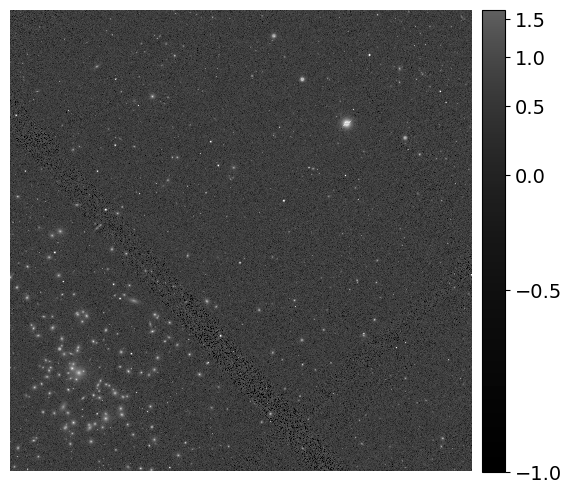

In [48]:
fig = plt.figure(figsize=(10, 6))
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(my_new_deepCoadd.image)
plt.gca().axis('off')

### 4.2.5. Retrieve the configurations for the run

In this example, only one configuration parameter was changed from the default values. This was in Section 3.4 where we set:
`assembleCoaddPipeline.addConfigOverride('makeWarp', 'doApplyFinalizedPsf', False)`.

The configurations can be retrieved for the in `simpleButler` with the following calls.

In [49]:
my_makeWarp_config = simpleButler.get("makeWarp_config", my_dataId)

In [50]:
my_assembleCoadd_config = simpleButler.get("assembleCoadd_config", my_dataId)

**Option:** print all of the keys and values for each pipeline tasks's configuration.

In [ ]:
# for key, value in my_makeWarp_config.items():
#     print(key, value)

In [ ]:
# for key, value in my_assembleCoadd_config.items():
#     print(key, value)

# 5. Exercises for the learner

1. **Use the next tutorial notebook in the series (09b_Custom_Coadd_Sources.ipynb) to do source detection and measurement on the new custom coadd, and compare with results from the original deepCoadd.**
2. Create a coadd for date Window2. Restart the kernel and clear all outputs. Edit Section 3 to use Window2. Note that when you get to rerunning Section 4.1 for Window2, the coadd_index will be different.
3. Use airmass constraints instead of MJD to identify the subset of visits to coadd. Hint: use `my_coadd_visits_airmass = visitTable.loc[my_coadd_inputs.visits['id']]['airmass']`.